# Team: Kayla and Hariraj

# Dataset3: Alcohol Sales

https://www.kaggle.com/datasets/bulentsiyah/for-simple-exercises-time-series-forecasting/data?select=Alcohol_Sales.csv

# Preamble

In [220]:
# import relevant Python libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import seaborn as sns



# A. Exploration of Dataset

In [221]:
df_alcohol_sales =pd.read_csv('Alcohol_Sales.csv')
num_samples = df_alcohol_sales.shape[0]
num_variables = df_alcohol_sales.shape[1]
print(df_alcohol_sales.axes)
print(df_alcohol_sales.dtypes)
print(df_alcohol_sales.head(10))

[RangeIndex(start=0, stop=325, step=1), Index(['DATE', 'S4248SM144NCEN'], dtype='object')]
DATE              object
S4248SM144NCEN     int64
dtype: object
         DATE  S4248SM144NCEN
0  1992-01-01            3459
1  1992-02-01            3458
2  1992-03-01            4002
3  1992-04-01            4564
4  1992-05-01            4221
5  1992-06-01            4529
6  1992-07-01            4466
7  1992-08-01            4137
8  1992-09-01            4126
9  1992-10-01            4259


In [222]:

print("There are ", num_samples, 'samples and ', num_variables, 'raw features')


There are  325 samples and  2 raw features


In [223]:
columns = df_alcohol_sales.columns




isna_columns = []
for x in columns:
    count = df_alcohol_sales[x].isna().sum()
    if count > 0:
        isna_columns.append(x)

print("There are", len(isna_columns), 'columns with missing values.')

There are 0 columns with missing values.


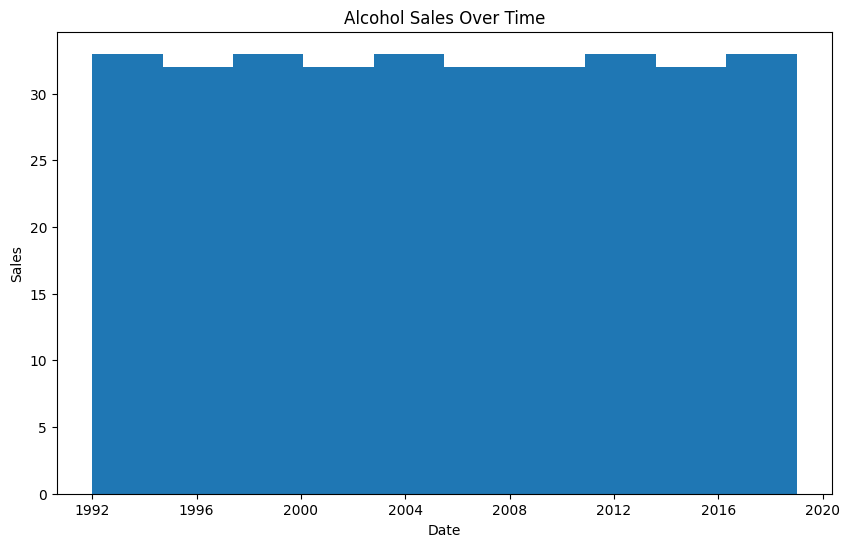

In [224]:
df_alcohol_sales['DATE'] = pd.to_datetime(df_alcohol_sales['DATE'])
df_alcohol_sales = df_alcohol_sales.sort_values('DATE')
plt.figure(figsize=(10, 6))
plt.hist(df_alcohol_sales['DATE'])
plt.title('Alcohol Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

According to the exploration of the dataset, we have learned that there are 2 features total. One of these features is an independent variables: DATE, and the other is a dependent variable, alcohol sales. The data in this dataset is raw data. It has not yet been pre processed, we can tell that it hasn't been pre processed since the 'DATE' column is an object type instead of DATE type. The dependent variable of alcohol sales is a numerical variable. 

# B. Pre Processing

The first step in pre processing, is changing the 'DATE' column from the object type to date form so we are able to use the data for processing in later steps. This is done below. Additionally, we will sort the data by its date in ascending order. I did this referencing the pandas documentation[1] and [2].

In [225]:
df_alcohol_sales['DATE'] = pd.to_datetime(df_alcohol_sales['DATE'])

df_alcohol_sales = df_alcohol_sales.sort_values('DATE')



Next, we will standardize the numerical variable of alcohol sales. 

In [226]:

df_alcohol_sales['S4248SM144NCEN'] = (df_alcohol_sales['S4248SM144NCEN'] - df_alcohol_sales['S4248SM144NCEN'].mean()) / df_alcohol_sales['S4248SM144NCEN'].std()

print(df_alcohol_sales.head(20))


         DATE  S4248SM144NCEN
0  1992-01-01       -1.519215
1  1992-02-01       -1.519558
2  1992-03-01       -1.332890
3  1992-04-01       -1.140046
4  1992-05-01       -1.257742
5  1992-06-01       -1.152056
6  1992-07-01       -1.173673
7  1992-08-01       -1.286566
8  1992-09-01       -1.290341
9  1992-10-01       -1.244703
10 1992-11-01       -1.251223
11 1992-12-01       -1.012398
12 1993-01-01       -1.666078
13 1993-02-01       -1.587156
14 1993-03-01       -1.278674
15 1993-04-01       -1.204213
16 1993-05-01       -1.228233
17 1993-06-01       -1.094751
18 1993-07-01       -1.176418
19 1993-08-01       -1.176762


Lastly, we replace the NaN values with the emprical mean.

In [227]:

empirical_median = df_alcohol_sales['S4248SM144NCEN'].median()
df_alcohol_sales.replace({'S4248SM144NCEN':'NaN'}, {'S4248SM144NCEN': empirical_median}, inplace=True)

# C. Feature Extraction/ Feature Engineering

Referenced the medium article on feature engineering for this portion of the assignment. [3]

First, I used the datetime functionality to add features to represent the year, month, day, day of week, and quarter. This will allow us to see if these features affect the alcohol sale. I also used the rolling mean/rolling STD. The rolling window calculates the mean and STD of the window of days three days ahead of the current date and three days behind the current date. 

I also added 3 shifted lag featuers. This can help to notice trends at reoccuring times, such as everyday at 4 pm. 

In [228]:
df_alcohol_sales['year'] = df_alcohol_sales['DATE'].dt.year
df_alcohol_sales['month'] = df_alcohol_sales['DATE'].dt.month
df_alcohol_sales['day'] = df_alcohol_sales['DATE'].dt.day
df_alcohol_sales['day_of_week'] = df_alcohol_sales['DATE'].dt.dayofweek
df_alcohol_sales['quarter'] = df_alcohol_sales['DATE'].dt.quarter

df_alcohol_sales['rolling_mean'] = df_alcohol_sales['S4248SM144NCEN'].rolling(window=3).mean()
df_alcohol_sales['rolling_std'] = df_alcohol_sales['S4248SM144NCEN'].rolling(window=3).std()

df_alcohol_sales['lag_1'] = df_alcohol_sales['S4248SM144NCEN'].shift(1)
df_alcohol_sales['lag_2'] = df_alcohol_sales['S4248SM144NCEN'].shift(2)
df_alcohol_sales['lag_3'] = df_alcohol_sales['S4248SM144NCEN'].shift(3)


Next, I standardized the data using the calculated means, stds, and lags. 

In [229]:
scaler = StandardScaler()
df_alcohol_sales[['S4248SM144NCEN', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std']] = scaler.fit_transform(
    df_alcohol_sales[['S4248SM144NCEN', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std']]
)

Finally, here is the feature engineered data. 

In [230]:
df_alcohol_sales = df_alcohol_sales.dropna()
print(df_alcohol_sales.head(20))

         DATE  S4248SM144NCEN  year  month  day  day_of_week  quarter  \
3  1992-04-01       -1.141804  1992      4    1            2        2   
4  1992-05-01       -1.259682  1992      5    1            4        2   
5  1992-06-01       -1.153832  1992      6    1            0        2   
6  1992-07-01       -1.175483  1992      7    1            2        3   
7  1992-08-01       -1.288550  1992      8    1            5        3   
8  1992-09-01       -1.292330  1992      9    1            1        3   
9  1992-10-01       -1.246623  1992     10    1            3        4   
10 1992-11-01       -1.253152  1992     11    1            6        4   
11 1992-12-01       -1.013959  1992     12    1            1        4   
12 1993-01-01       -1.668647  1993      1    1            4        1   
13 1993-02-01       -1.589604  1993      2    1            0        1   
14 1993-03-01       -1.280646  1993      3    1            0        1   
15 1993-04-01       -1.206070  1993      4    1    

# D. Processing of Dataset using two different machine learning methods

Method 1: Linear Regression

To execute the least squares regression training, I used articles [4] and [5] listed in the bibliography below. 

        DATE  S4248SM144NCEN  year  month  day  day_of_week  quarter  \
3 1992-04-01       -1.141804  1992      4    1            2        2   
4 1992-05-01       -1.259682  1992      5    1            4        2   
5 1992-06-01       -1.153832  1992      6    1            0        2   
6 1992-07-01       -1.175483  1992      7    1            2        3   
7 1992-08-01       -1.288550  1992      8    1            5        3   

   rolling_mean  rolling_std     lag_1     lag_2     lag_3  \
3     -1.390773    -0.353612 -1.331839 -1.524630 -1.526556   
4     -1.299571    -0.820102 -1.138712 -1.335961 -1.526905   
5     -1.236578    -0.983574 -1.256581 -1.141049 -1.337107   
6     -1.248292    -1.028580 -1.150740 -1.260008 -1.141029   
7     -1.258332    -0.945937 -1.172389 -1.153188 -1.260700   

   Linear Regression Prediction  
3                     -1.141804  
4                     -1.259682  
5                     -1.153832  
6                     -1.175483  
7                     -1

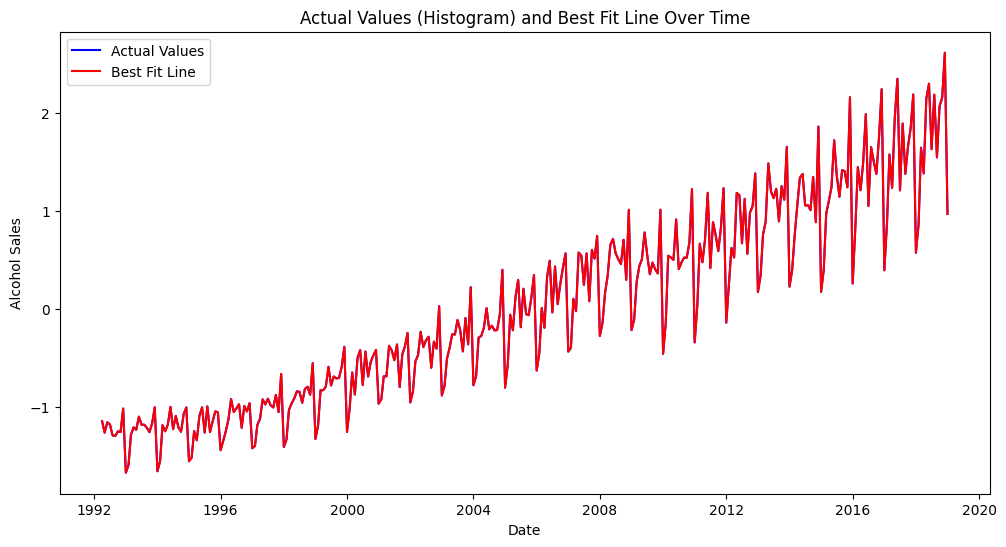

In [231]:
target ='S4248SM144NCEN'
features = ['year', 'month', 'day', 'day_of_week', 'quarter', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_2', 'lag_3']
X = df_alcohol_sales[features]
y = df_alcohol_sales[target]

lr_model = make_pipeline(StandardScaler(), LinearRegression())
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(lr_model, X, y, cv=kf)
df_alcohol_sales['Linear Regression Prediction'] = y_pred
print(df_alcohol_sales.head())

fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(x=df_alcohol_sales['DATE'], y=df_alcohol_sales['S4248SM144NCEN'], color='blue',  label='Actual Values', ax=ax)

sns.lineplot(x=df_alcohol_sales['DATE'], y=df_alcohol_sales['Linear Regression Prediction'], color='red', label='Best Fit Line', ax=ax)

plt.xlabel('Date')
plt.ylabel('Alcohol Sales')
plt.title('Actual Values (Histogram) and Best Fit Line Over Time')

plt.legend()
plt.show()

For the first method, I chose to use linear regression because by looking at the pre processed data, I could see that as the time increased, the sales increased as well. Therefore, I could guess that the data could follow a linear increase. To do this, I first split up my dataframe into independent features and my target feature which is alcohol sales. I then used APIs to make a linear regression pipeline. I used a 5 fold split meaning that the data will be split into five chunks: 4 for training and one for testing. Finally, I plotted the predictions against the actual values on a scatter plot. By looking at this scatterplot as well as the updated dataframe, I can tell that linear regression was pretty accurate. 

Method 2: Ridge Regression

To execute the Ridge regression, I referenced articles [8] and [9]

         DATE  S4248SM144NCEN  year  month  day  day_of_week  quarter  \
3  1992-04-01       -1.141804  1992      4    1            2        2   
4  1992-05-01       -1.259682  1992      5    1            4        2   
5  1992-06-01       -1.153832  1992      6    1            0        2   
6  1992-07-01       -1.175483  1992      7    1            2        3   
7  1992-08-01       -1.288550  1992      8    1            5        3   
8  1992-09-01       -1.292330  1992      9    1            1        3   
9  1992-10-01       -1.246623  1992     10    1            3        4   
10 1992-11-01       -1.253152  1992     11    1            6        4   
11 1992-12-01       -1.013959  1992     12    1            1        4   
12 1993-01-01       -1.668647  1993      1    1            4        1   
13 1993-02-01       -1.589604  1993      2    1            0        1   
14 1993-03-01       -1.280646  1993      3    1            0        1   
15 1993-04-01       -1.206070  1993      4    1    

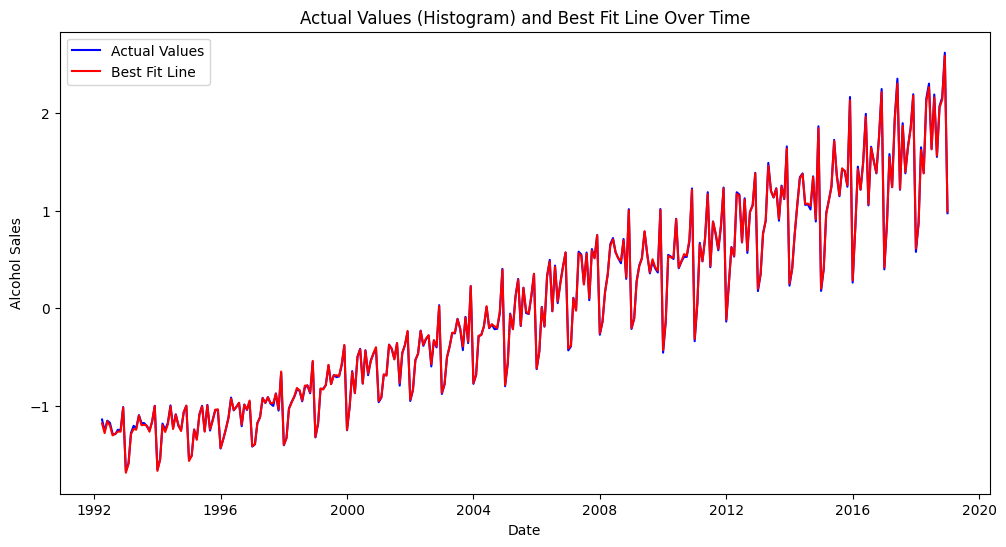

In [232]:
c =[0.1, 1.0, 10.0]
ridge_cv = RidgeCV(alphas = c, store_cv_values=True)
ridge_cv.fit(X, y)
best_c = ridge_cv.alpha_
ridge = RidgeCV(alphas = [best_c])
ridge.fit(X, y)
cv_results = cross_val_score(ridge, X, y, cv=5)  # You can adjust the number of folds (cv) as needed
average_cv_score = cv_results.mean()
df_alcohol_sales['ridge_predictions'] = ridge.predict(X)
print(df_alcohol_sales.head(20))

fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(x=df_alcohol_sales['DATE'], y=df_alcohol_sales['S4248SM144NCEN'], color='blue',  label='Actual Values', ax=ax)

sns.lineplot(x=df_alcohol_sales['DATE'], y=df_alcohol_sales['ridge_predictions'], color='red', label='Best Fit Line', ax=ax)

plt.xlabel('Date')
plt.ylabel('Alcohol Sales')
plt.title('Actual Values (Histogram) and Best Fit Line Over Time')

plt.legend()
plt.show()

For the second method, I used ridge regression because that is the method I was most comfortable with in class after linear regression. I used 3 different values of C as a parameter. I used the Ridge API to train the model and then chose which out of the three c values gave the best final results. Similar to the previous method, I used 5 fold cross validation and took the average of each of the scores. Lastly, I added these predictions to the dataframe. Based on the plot, I can tell that this prediction was also pretty accurate, however not perfect as you can see some of the discrepensies from the blue and red lines. 

# E. Comparative Analysis of the two methods

Used articles [6] and [7] for this section

Metrics For Linear Regression

In [233]:
#Mean squared error
mse = mean_squared_error(y, df_alcohol_sales['Linear Regression Prediction'])
print(f'Mean Squared Error: {mse}')

#R2 metric
r2 = r2_score(y, df_alcohol_sales['Linear Regression Prediction'])
print("R2 Score:", r2)

Mean Squared Error: 7.856485133245301e-30
R2 Score: 1.0


Metrics for Ridge Regression

In [234]:
#Mean squared error
mse = mean_squared_error(y, df_alcohol_sales['ridge_predictions'])
print(f'Mean Squared Error: {mse}')

#R2 metric
r2 = r2_score(y, df_alcohol_sales['ridge_predictions'])
print("R2 Score:", r2)

Mean Squared Error: 0.00018259162535381158
R2 Score: 0.9998154175594958


Based on the metrics of both models, I see that both performed very well with high R2 scores and low mean squared error. Therefore, I would chose either of the two methods. 

# F. Discussion on ethical isues

This dataset may have some ethical concerns that are important to note through the processing and analysis of this data. One concern is a privacy concern. Although the only features of this dataset are time and sales, it must be ensured that individuals private information such as name, credit card, address, etc. is not included in the data for these models without the individuals consent. Another ethical concern is what this data is being used for and if it being missues. Alcohol consumption is a touchy subject that may impact some populations more than others therefore it is important that this data is not used to attack certain groups of people. This issue also corresponds to bias. 

# G. Bibliography

[1] https://pandas.pydata.org/docs/user_guide/timeseries.html
[2] https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
[3] https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0
[4] https://pythonnumericalmethods.berkeley.edu/notebooks/chapter16.04-Least-Squares-Regression-in-Python.html
[5]https://medium.com/datasparq-technology/a-least-squares-solution-to-time-series-forecasting-e438a6d510fa
[6] https://www.dataquest.io/blog/understanding-regression-error-metrics/
[7]https://thecleverprogrammer.com/2021/06/22/r2-score-in-machine-learning/
[8] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
[9] https://medium.com/analytics-vidhya/ridge-and-lasso-regression-in-python-60cf1af69cfe
